In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
import h5py
import matplotlib.image as mpimg
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import json
import xmltodict
import sys
from skimage import io
# import neccessary packages
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
trainPath = r"G:/APS 360 project/Dataset/人脸口罩检测数据集/extracted/train/"
valPath = r"G:/APS 360 project/Dataset/人脸口罩检测数据集/extracted/val/"

In [576]:
resnet = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\zxc21/.cache\torch\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:52<00:00, 10.6MB/s]


In [577]:
resnet.

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [579]:
resnet = models.vgg16(pretrained=True)
resnet.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1000, out_features=8, bias=True),
    nn.Sigmoid(),
)

In [580]:
resnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [15]:
resnet.fc = nn.Sequential(
    nn.Linear(512, 200),
    nn.ReLU(),
    nn.Linear(200, 14),
)

In [16]:
get_parameter_number(resnet)

{'Total': 11281926, 'Trainable': 11281926}

In [4]:
def get_imlist(path):
    return [ os.path.join(path,f) for f in os.listdir(path) if (f.endswith('.png') and ( not f.endswith("labeled.png") ) ) ]

def get_lblist(path):
    return [ os.path.join(path,f) for f in os.listdir(path) if f.endswith('.npy')  ]

In [5]:
train_img_list = get_imlist(trainPath)
train_lb_list = get_lblist(trainPath)

val_img_list = get_imlist(valPath)
val_lb_list = get_lblist(valPath)

In [6]:
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, label_list, picture_list, transform=None):
        # 1. Initialize file path or list of file names.
        self.label_list = label_list
        self.picture_list = picture_list
        self.transform = transform
    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        image = Image.open(self.picture_list[index])
        label = np.load(self.label_list[index])
        if self.transform:
            image = self.transform(image)

        label = torch.from_numpy(label)
        
        sample = {"image":image, "label":label}
        return sample
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.picture_list)

In [7]:
traindt = FaceDataset(train_lb_list, train_img_list, transforms.ToTensor())
valdt = FaceDataset(val_lb_list, val_img_list, transforms.ToTensor())

In [8]:
train_dataloader = torch.utils.data.DataLoader(traindt, batch_size=8,
                        shuffle=True, num_workers=0)

val_dataloader = torch.utils.data.DataLoader(valdt, batch_size=8,
                        shuffle=True, num_workers=0)

In [51]:
trainSample = next(iter(train_dataloader))

In [59]:
resnet(trainSample["image"]).shape

torch.Size([8, 14])

In [9]:
boxnet = models.vgg16(pretrained=True)
boxnet.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1000, out_features=8, bias=True),
    nn.Sigmoid(),
)

In [11]:
class DIOULoss(nn.Module):
    def __init__(self):
        super(DIOULoss, self).__init__()

    def forward(self, bboxes1, bboxes2, weight = None):
        rows = bboxes1.shape[0]
        cols = bboxes2.shape[0]
        dious = torch.zeros((rows, cols))
        if rows * cols == 0:#
            return dious
        exchange = False
        if bboxes1.shape[0] > bboxes2.shape[0]:
            bboxes1, bboxes2 = bboxes2, bboxes1
            dious = torch.zeros((cols, rows))
            exchange = True
        # #xmin,ymin,xmax,ymax->[:,0],[:,1],[:,2],[:,3]
        w1 = bboxes1[:, 2] - bboxes1[:, 0]
        h1 = bboxes1[:, 3] - bboxes1[:, 1] 
        w2 = bboxes2[:, 2] - bboxes2[:, 0]
        h2 = bboxes2[:, 3] - bboxes2[:, 1]
        
        area1 = w1 * h1
        area2 = w2 * h2

        center_x1 = (bboxes1[:, 2] + bboxes1[:, 0]) / 2 
        center_y1 = (bboxes1[:, 3] + bboxes1[:, 1]) / 2 
        center_x2 = (bboxes2[:, 2] + bboxes2[:, 0]) / 2
        center_y2 = (bboxes2[:, 3] + bboxes2[:, 1]) / 2

        inter_max_xy = torch.min(bboxes1[:, 2:],bboxes2[:, 2:]) 
        inter_min_xy = torch.max(bboxes1[:, :2],bboxes2[:, :2]) 
        out_max_xy = torch.max(bboxes1[:, 2:],bboxes2[:, 2:]) 
        out_min_xy = torch.min(bboxes1[:, :2],bboxes2[:, :2])

        inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
        inter_area = inter[:, 0] * inter[:, 1]
        inter_diag = (center_x2 - center_x1)**2 + (center_y2 - center_y1)**2
        outer = torch.clamp((out_max_xy - out_min_xy), min=0)
        outer_diag = (outer[:, 0] ** 2) + (outer[:, 1] ** 2)
        union = area1+area2-inter_area
        dious = (inter_area + 1e-6) / (union + 1e-6) - (inter_diag + 1e-6) / (outer_diag + 1e-6)
        dious = torch.clamp(dious,min=-1.0,max = 1.0)
        if exchange:
            dious = dious.T
        return torch.mean(1 - dious) if weight == None else torch.mean( (1 - dious) * weight)

In [228]:
classnet = models.resnet18(pretrained=True)
classnet.fc = nn.Sequential(
    nn.Linear(512, 200),
    nn.ReLU(),
    nn.Linear(200, 6),
)

In [10]:
import faceL_utilitiscopy

In [116]:
trainSample["label"][0]

tensor([0.0000, 0.0000, 1.0000, 0.9648, 0.5371, 0.9873, 0.5654, 0.0000, 0.0000,
        1.0000, 0.9512, 0.5049, 0.9707, 0.5293], dtype=torch.float64)

In [12]:
def trainCNN(net, train_data, lr = 0.001, epochs = 5, bs = 8):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs,
                        shuffle=True, num_workers=0)

    net = net.to(device)

    loss_func1 = nn.CrossEntropyLoss()

    loss_func2 = nn.MSELoss()

    loss_func3= DIOULoss()

    opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

    itera = 0


    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data["image"].float(), data["label"].float()

            inputs = torch.autograd.Variable(inputs, requires_grad=False) 
            labels = torch.autograd.Variable(labels, requires_grad=False) 

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)

            # loss1 = loss_func1(outputs[:, 0:3], labels[:, 0:3].argmax(dim = 1))
            # loss2 = loss_func1(outputs[:, 3:6], labels[:, 7:10].argmax(dim = 1))



            loss3 =   loss_func3( outputs[:, 0:4], labels[:, 3:7], (1 + labels[:, 7]) * (1 - labels[:, 0]) ) 

            loss4 = loss_func3( outputs[:, 4:8], labels[:, 10:14], (1 - labels[:, 7]) * (1 + labels[:, 0]) )  


            total_loss = ( loss3 +   loss4) / 2.0

            
            opt.zero_grad()
            total_loss.backward()
            opt.step()

            itera += 1

            print("\r"+ "Epoch: " + str(epoch) + " Iterations: " + str(itera) + " Loss: " + "{:0.3f}".format( total_loss ) ,end = "",flush=True)

In [258]:

torch.save(boxnet, "boxnet1.pth")

In [109]:
trainCNN(resnet, traindt, lr = 0.001, bs = 32)

Epoch: 4 Iterations: 1265 Loss: 0.094

In [142]:
trainCNN(boxnet, traindt, lr = 0.0001, bs = 16, epochs = 20)

Epoch: 10 Iterations: 5172 Loss: 0.536

KeyboardInterrupt: 

In [231]:
trainCNN(classnet, traindt, lr = 0.0001, bs = 64)

Epoch: 4 Iterations: 635 Loss: 0.153

In [85]:
resnet.to("cpu")(trainSample["image"])[0]

tensor([-81.4691,  -9.9634,   9.8408,   0.6336,   0.4736,   0.6538,   0.5143,
         -4.3183, -13.3191,   6.4380,   0.6511,   0.4837,   0.6655,   0.4931],
       grad_fn=<SelectBackward>)

In [86]:
resnet.to("cpu")(trainSample["image"])[3]

tensor([-30.8255,  -5.5624,   6.0706,   0.4287,   0.3125,   0.5148,   0.4225,
          1.1597,  -9.8040,   0.9892,   0.1676,   0.1120,   0.1828,   0.1330],
       grad_fn=<SelectBackward>)

In [254]:
n = 1856
imgfile = val_img_list[n]
img =Image.open(imgfile)

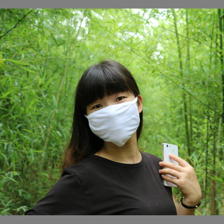

In [255]:
img

In [256]:
pred = boxnet.to("cpu")( transforms.ToTensor()(img).unsqueeze(dim=0) )
pred

tensor([[0.3749, 0.3590, 0.6334, 0.6972, 0.3245, 0.3974, 0.7245, 0.6483]],
       grad_fn=<SigmoidBackward>)

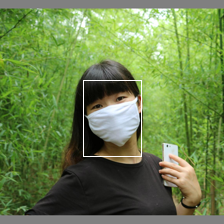

In [257]:
ig = img.copy()
draw = ImageDraw.Draw(ig)
draw.rectangle([pred[0][0] * 224, pred[0][1] * 224, pred[0][2] * 224, pred[0][3] * 224])
ig

In [443]:
import math

In [480]:
def Diou(bboxes1, bboxes2):
    rows = bboxes1.shape[0]
    cols = bboxes2.shape[0]
    dious = torch.zeros((rows, cols))
    if rows * cols == 0:#
        return dious
    exchange = False
    if bboxes1.shape[0] > bboxes2.shape[0]:
        bboxes1, bboxes2 = bboxes2, bboxes1
        dious = torch.zeros((cols, rows))
        exchange = True
    # #xmin,ymin,xmax,ymax->[:,0],[:,1],[:,2],[:,3]
    w1 = bboxes1[:, 2] - bboxes1[:, 0]
    h1 = bboxes1[:, 3] - bboxes1[:, 1] 
    w2 = bboxes2[:, 2] - bboxes2[:, 0]
    h2 = bboxes2[:, 3] - bboxes2[:, 1]
    
    area1 = w1 * h1
    area2 = w2 * h2

    center_x1 = (bboxes1[:, 2] + bboxes1[:, 0]) / 2 
    center_y1 = (bboxes1[:, 3] + bboxes1[:, 1]) / 2 
    center_x2 = (bboxes2[:, 2] + bboxes2[:, 0]) / 2
    center_y2 = (bboxes2[:, 3] + bboxes2[:, 1]) / 2

    inter_max_xy = torch.min(bboxes1[:, 2:],bboxes2[:, 2:]) 
    inter_min_xy = torch.max(bboxes1[:, :2],bboxes2[:, :2]) 
    out_max_xy = torch.max(bboxes1[:, 2:],bboxes2[:, 2:]) 
    out_min_xy = torch.min(bboxes1[:, :2],bboxes2[:, :2])

    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[:, 0] * inter[:, 1]
    inter_diag = (center_x2 - center_x1)**2 + (center_y2 - center_y1)**2
    outer = torch.clamp((out_max_xy - out_min_xy), min=0)
    outer_diag = (outer[:, 0] ** 2) + (outer[:, 1] ** 2)
    union = area1+area2-inter_area
    dious = (inter_area + 1e-6) / (union + 1e-6) - (inter_diag + 1e-6) / (outer_diag + 1e-6)
    dious = torch.clamp(dious,min=-1.0,max = 1.0)
    if exchange:
        dious = dious.T
    return dious

In [496]:
1 - Diou(torch.tensor([[0.1,0.1,0.2,0.25], [0,0,0.01,0.01]]).float() , torch.tensor([[0.2,0.2,0.3,0.3], [0,0,0.01,0.011]]).float() )

tensor([1.1953, 0.0957])

In [90]:
import dataProcessing as dp

In [92]:
def drawBoxLabeled(picFile, labels, ratio = True):

    labels = labels.squeeze()

    image = Image.open(picFile)
    img = image.copy()
    draw = ImageDraw.Draw(img)
    face1 = [0,0,0,0,0,0,0]
    face2 = [0,0,0,0,0,0,0]
    face1[labels.squeeze()[0:3].argmax()] = 1
    face2[labels.squeeze()[7:10].argmax()] = 1

    


    face1[3:] = labels[3:7].numpy().tolist()
    face2[3:] = labels[10:14].numpy().tolist()


    faces = [face1, face2]

    for i in faces:
        if ratio:
            i = (np.array(i) * np.array([1,1,1,image.size[0],image.size[1],image.size[0],image.size[1]])).astype(np.int).tolist()
        draw.rectangle(i[3:], outline=(255, 0, 0) if i[2] == 1 else ( (0, 255, 0) if i[1] == 1 else  (255, 0, 0) ), width=1)
    return img

In [99]:
def getPredFromPath(path, net1):
    transform = transforms.ToTensor()
   
    img = Image.open(path)
    img = transform(img)
    
    x = Variable(torch.unsqueeze(img, dim=0).float(), requires_grad=False)

    l = net1(x).squeeze()

    return l

In [100]:
def drawPred (imgName):
    pred = getPredFromPath(imgName, resnet)
    return drawBoxLabeled(imgName, pred.cpu().detach(), True)